In [26]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import random
# import torch.nn.functional as F
from torchvision.transforms import functional as F

In [ ]:
# !pip install --upgrade albumentations
# import albumentations as A

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## To Do: 

##### Build the model look at Pytorch docs https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
##### Get the train function to integrate with model and class data https://github.com/pytorch/vision/tree/master/references/detection. Just make sure I can train on train_loader without errors.
##### Label Data and put them in the csv file (might need to do this before training). 
##### Zero_base_line in train function like training a neural network 


##### Add to the spreadsheet by getting info about agencies or research that is to help people who suffer from blindness.


## Links 
* Model: 
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

* For Albumentations look at open source github
For Cropping 
https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/crops/transforms.py
https://github.com/albumentations-team/albumentations/blob/ae50578a46e5981eccaafee311a3ee0b4b7992b2/albumentations/augmentations/crops/functional.py#L22


In [27]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Fruit Defects Dataset HalfWay.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [28]:
#For one strawberry batch please drop watermark rows
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)
rottenStrawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch1RottenStrawBerryLabels/RottenStrawberriesBatch1Labels.csv", header = None)
rottenStrawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch2RottenStrawBerryLabels/RottenStrawBerryBatch2.csv", header = None)
rottenStrawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch3RottenStrawberrylabel/rottenStrawberryBtch3labels.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, 
                          rottenApple_csv_batch_2, rottenApple_csv_batch_3, rottenStrawberry_csv_batch_1, rottenStrawberry_csv_batch_2, 
                          rottenStrawberry_csv_batch_3]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))
assert total_row_sum_check == fruit_df.shape[0]
print("DataFrame shape: {}".format(fruit_df.shape))
print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))
  


Checked total rows from all the dataframes combined: 844
DataFrame shape: (844, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots']
Number of Unique Images 246


In [29]:
#Post Processing 
fruit_df = fruit_df[fruit_df["Image_id"] != "FreshStrawberries15.jpeg"]

In [30]:
bounding_box_dict = dict()
labels_dict = dict()
classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))

245
245


In [ ]:
# transform = A.Compose([
#     A.RandomCrop(width=80, height=80),
#     A.HorizontalFlip(p=1),
#     A.RandomRain(), 
#     A.RandomBrightnessContrast(p=0.2),
# ], bbox_params=A.BboxParams(format='coco'))

In [ ]:
hhj = cv2.cvtColor(cv2.imread("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApples30.jpeg"), cv2.COLOR_BGR2RGB)
# bboy = bounding_box_dict["RottenApples30.jpeg"]
hhj = F.to_tensor(hhj)
# hhj = hhj.flip(-1)
bboy = bounding_box_dict["RottenApples30.jpeg"]
bboy = torch.tensor(bboy, dtype= torch.float32)
# [channels, height, width]

In [ ]:
def get_random_crop_coords(height: int, width: int, crop_height: int, crop_width: int, h_start: float, w_start: float):
    y1 = int((height - crop_height) * h_start)
    y2 = y1 + crop_height
    x1 = int((width - crop_width) * w_start)
    x2 = x1 + crop_width
    return x1, y1, x2, y2

def random_crop(img: torch.Tensor, crop_height: int, crop_width: int, h_start: float, w_start: float):
    height, width = img.size(1), img.size(2)
    if height < crop_height or width < crop_width:
        raise ValueError(
            "Requested crop size ({crop_height}, {crop_width}) is "
            "larger than the image size ({height}, {width})".format(
                crop_height=crop_height, crop_width=crop_width, height=height, width=width
            )
        )
    x1, y1, x2, y2 = get_random_crop_coords(height, width, crop_height, crop_width, h_start, w_start)
    img = img[y1:y2, x1:x2]
    return img

# def bbox_random_crop(
#     bbox: torch.Tensor, crop_height: int, crop_width: int, h_start: float, w_start: float, rows: int, cols: int
# ):
#     crop_coords = get_random_crop_coords(rows, cols, crop_height, crop_width, h_start, w_start)
#     return crop_bbox_by_coords(bbox, crop_coords, crop_height, crop_width, rows, cols)


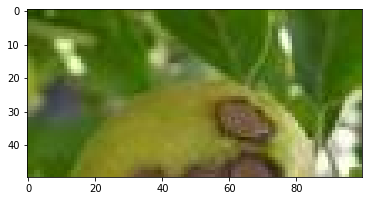

In [ ]:
hhj = random_crop(hhj, 50, 50, 0, 0)
plt.imshow(hhj.permute(1, 2, 0).numpy())

In [ ]:
hhj.size()

torch.Size([3, 100, 100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


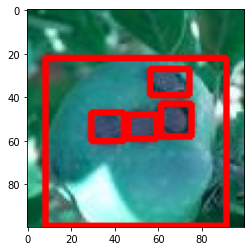

In [ ]:
hhj = hhj.permute(1, 2, 0).numpy()
hhj = cv2.cvtColor(hhj, cv2.COLOR_BGR2RGB)
for i, box in enumerate(bboy):
      color = 255
      cv2.rectangle(
          hhj,
          (int(box[0]), int(box[1])),
          (int(box[0]) + int(box[2]), int(int(box[1])) + int(box[3])),
          color, 2
      )
plt.imshow(hhj)


In [ ]:
hhj = cv2.cvtColor(cv2.imread("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApples30.jpeg"), cv2.COLOR_BGR2RGB)

In [74]:
sha = torch.tensor([[ 84.,   8., 145., 140.],
        [ 88.,  19.,  66.,  67.]])

def find_area_bb(bb_coord):
  bb_coord = bb_coord.numpy()
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(pair_of_coord[2] * pair_of_coord[3])
  return torch.tensor(area_of_each_bb, dtype=torch.int32)


find_area_bb(sha)

tensor([20300,  4422], dtype=torch.int32)

## Class function

In [75]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  bb_coord = bb_coord.numpy()
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(pair_of_coord[2] * pair_of_coord[3])
  return torch.tensor(area_of_each_bb, dtype=torch.int32)

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())
    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths)

    # print(img_path)
    # print(idx)
    # print(self.imgs_key[idx])
    
    img = Image.open(img_path).convert("RGB") ## No Image path sometimes

    boxes = torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32)
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      img, target = self.transforms(img, target)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

### The Problem involved the differences between tensor, PIL, Numpy, and OpenCV and how they load images. 

Convert Tensor Image to numpy to do openCV operations. 
https://discuss.pytorch.org/t/convert-image-tensor-to-numpy-image-array/22887/2

PIL Loaded (y, x)
Numpy (x, y, d)
Torch (d, x, y) <- convert image to tensor and switch axis
Then convert to openCV since openCV can handle only a numpy array. 

Questions: 
Do I have to apply transforms on the labels/ boxes. I see it on the blog but I can't do it. 

Also, why when I take off shuffle does the dateiter fail. Why does it sometimes get a None error.

What I think is that the tensor image is ok. The reason the image flipped is because I Transposed it. When I did not transpose it, the openCV could recognize it b/c it only works well with the numpy shaped images. Therefore, all my code did was to turn that tensor image into something compatible with OpenCV so it can do its manipulations.

https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/transforms.py

This is the functional file (Can also just navigate the github). 

https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/functional.py

This link contains the raw albumentations code that is used to build these transforms

```
class HorizontalFlip(DualTransform):
    """Flip the input horizontally around the y-axis.
    Args:
        p (float): probability of applying the transform. Default: 0.5.
    Targets:
        image, mask, bboxes, keypoints
    Image types:
        uint8, float32
    """

    def apply(self, img, **params):
        if img.ndim == 3 and img.shape[2] > 1 and img.dtype == np.uint8:
            # Opencv is faster than numpy only in case of
            # non-gray scale 8bits images
            return F.hflip_cv2(img)

        return F.hflip(img)

    def apply_to_bbox(self, bbox, **params):
        return F.bbox_hflip(bbox, **params)

    def apply_to_keypoint(self, keypoint, **params):
        return F.keypoint_hflip(keypoint, **params)

    def get_transform_init_args_names(self):
        return ()
```

blog used to talk about albumentations
https://blog.paperspace.com/data-augmentation-for-bounding-boxes/

In [76]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            _,  width = image.shape[-2:]
            image = image.flip(-1)
            for bb_coord in target["boxes"]:
              bb_coord[0] = (width - (bb_coord[0] + bb_coord[2]))
              
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

In [77]:
#Using this stack overflow (https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders)
#(Suppose for example, you want to create batches of a list of varying dimension tensors. The below code pads sequences with 0 until the maximum sequence size of the batch,)
#Collate_fn is a function that is used to process your batches before you pass it to dataloader. In my case since I have different sized images I need a way to stack batches b/c torch.stack won't work.
#So I use zip which can accept tensors of different lengths and make them stacked with the size of the lowest length list given. Therefore stacking all the images in a batch 
#Successfully unlike torch.stack and doing that processing to every batch makes collate_fn vital since I have different image sizes.

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

np.random.seed(42)
torch.manual_seed(42)
batch_size = 32

def get_transform(train):
    transform = []
    transform.append(ToTensor())
    if train:
        transform.append(RandomHorizontalFlip(0.5))
    return Compose(transform)

train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transform(train = True))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn= collate_fn)

In [78]:
COLORS = [(255, 0, 0) for i in range(len(classes))]
COLORS[0] = (0, 0, 255)

def draw_boxes(boxes, labels, image):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[0]) + int(box[2]), int(int(box[1])) + int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

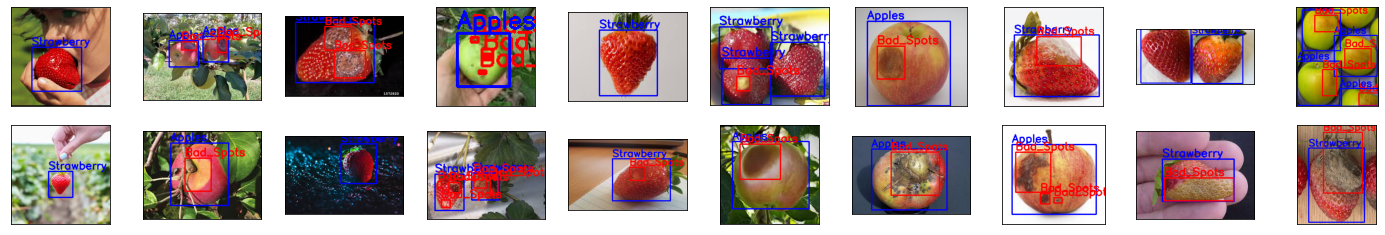

In [81]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = cv2.cvtColor(draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx]), cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [86]:
def train(net, epochs, train_loader, lr):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Check which parameters can calulate gradients. 
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr = lr)

    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    
    start_time = time.time()

    #For graphing
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):

            images = [image.to(device) for image in images]

            # target = list()
            # for t in targets:
            #   new_dict = dict()
            #   print(t)
            #   print("\n")
            #   for key, value in t.items():
            #     print(value)
            #     new_dict[key] = value.to(device)
            #   target.append(new_dict)
            
            print(targets)
            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

            optimizer.zero_grad()

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
                
            losses.backward()
            optimizer.step()

            train_loss +=  losses.item()
            print("Train_loss {}".format(train_loss))


In [37]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [43]:
resnet50_FCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 3
# get number of input features for the classifier
in_features = resnet50_FCNN.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
resnet50_FCNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [47]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

## This link shows the problem https://github.com/pytorch/vision/issues/2740
The answer from @oke-aditya is correct. You are probably passing to the model bounding boxes in the format [xmin, ymin, width, height], while Faster R-CNN expects boxes to be in [xmin, ymin, xmax, ymax] format.

Changing this should fix the issue.

We have btw recently added box conversion utilities to torchvision (thanks to @oke-aditya ), they can be found in

Look at box convert or doing it locally also works.

### https://github.com/pytorch/vision/blob/a98e17e50146529cdfadb590ba063e6bbee71de2/torchvision/ops/boxes.py#L137-L156




In [87]:
train(model, 2, train_loader, 0.001)

Device: cpu
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
[{'boxes': tensor([[ 24.,  16., 180., 138.],
        [ 91.,  26.,  61.,  54.],
        [113.,  81.,  71.,  62.]]), 'labels': tensor([1, 0, 0]), 'image_id': tensor([236]), 'area': tensor([24840,  3294,  4402], dtype=torch.int32)}, {'boxes': tensor([[ 49.,  67., 116., 112.],
        [ 81.,  96.,  57.,  50.]]), 'labels': tensor([2, 0]), 'image_id': tensor([61]), 'area': tensor([12992,  2850], dtype=torch.int32)}, {'boxes': tensor([[ 81.,   5., 150., 144.]]), 'labels': tensor([1]), 'image_id': tensor([14]), 'area': tensor([21600], dtype=torch.int32)}, {'boxes': tensor([[ 68.,  39., 126., 143.]]), 'labels': tensor([1]), 'image_id': tensor([24]), 'area': tensor([18018], dtype=torch.int32)}, {'boxes': tensor([[107.,  76.,  79.,  77.],
        [ 84.,  13.,  60.,  51.],
        [138.,  80.,  15.,  11.],
        [139.,  96.,  16.,  14.],
        [124., 115

ValueError: ignored

In [ ]:
boxes tensor([[djj], [wjdjjdjd]])
area tensor ([58, 90])